In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import glob
import pandas as pd
from plot_utils import *

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6.5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 2

sns.set_style('ticks')
sns.set_palette('Paired', 10)

In [3]:
simdex_df = pd.read_csv('simdex-timing.csv')
lemp_df = pd.read_csv('lemp-timing.csv')
blocked_mm_df = pd.read_csv('blocked_mm-timing.csv')

plot_utils.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lemp_rt['algo'] = 'LEMP'
plot_utils.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocked_mm_rt['algo'] = 'Blocked Matrix Multiply'


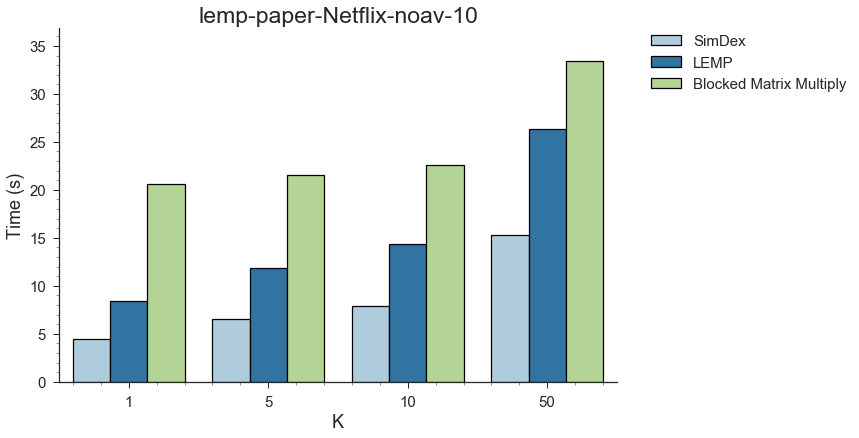

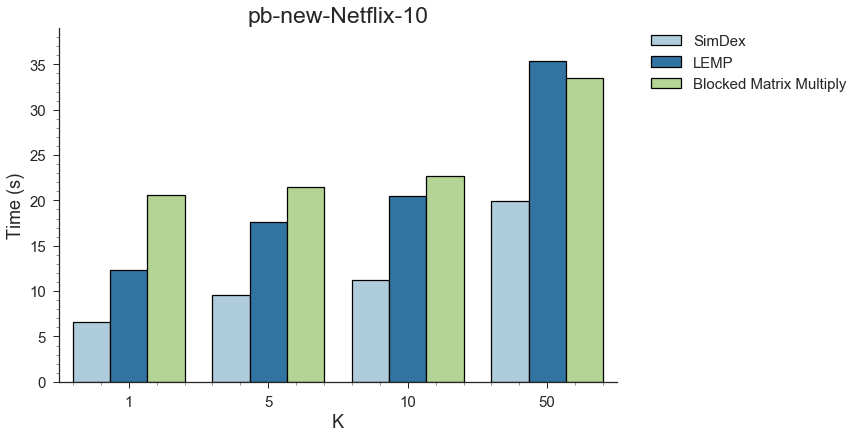

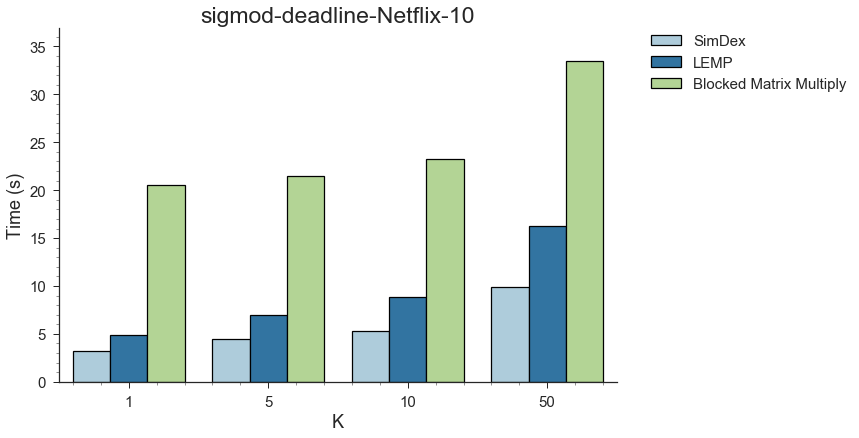

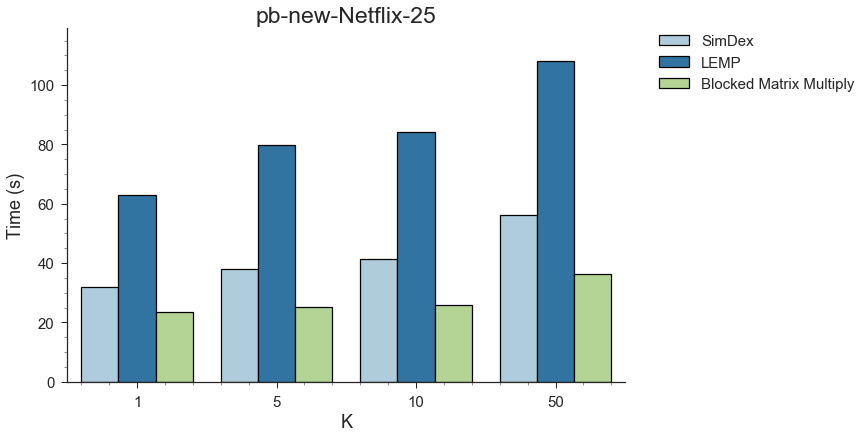

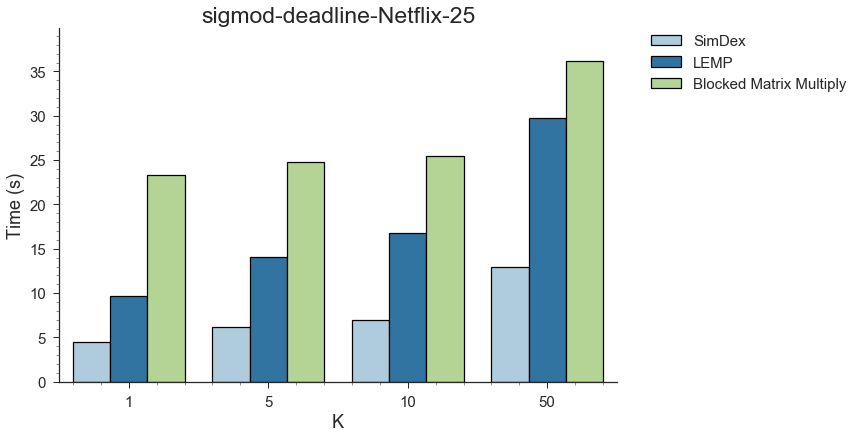

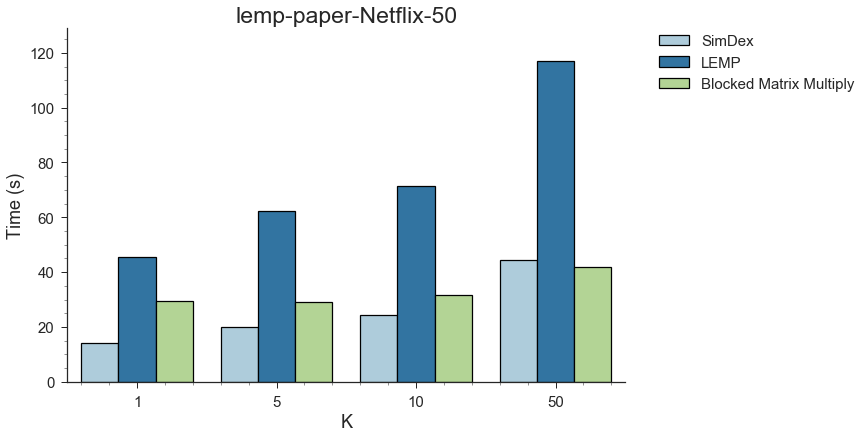

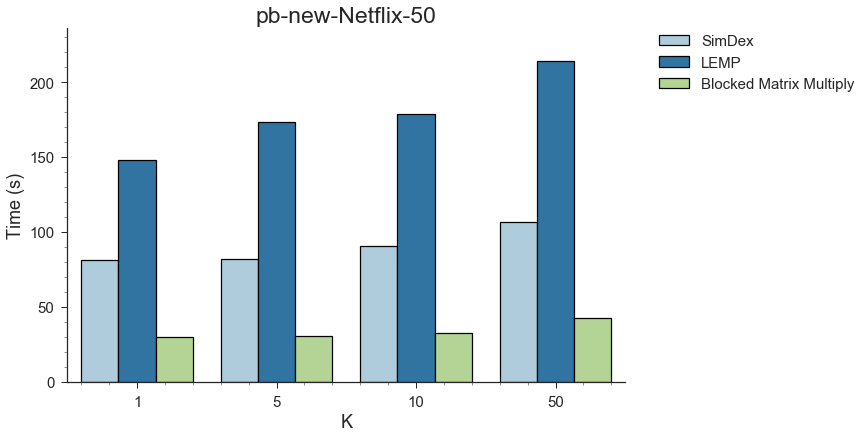

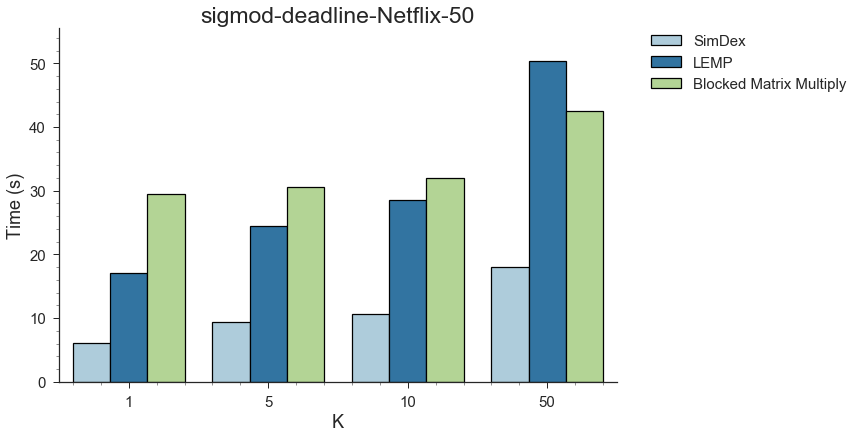

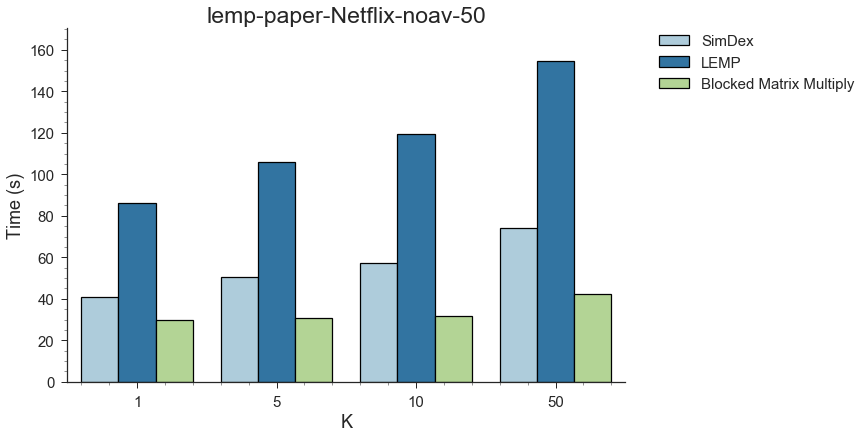

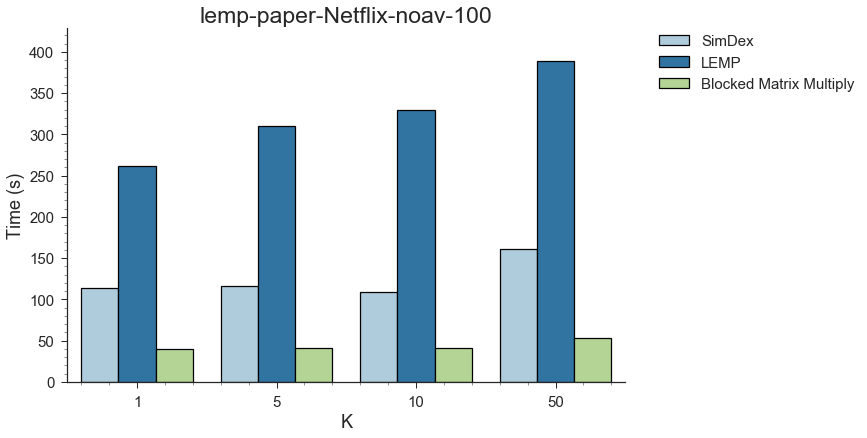

In [4]:
f_u_plots(simdex_df, lemp_df, blocked_mm_df)

In [5]:
simdex_df.sort_values(by='comp_time').groupby(
        ['model', 'K'], as_index=False).first().drop(['num_threads','num_latent_factors',
                                                      'batch_size','sample_percentage','num_iters'], axis=1)

,model,K,num_bins,num_clusters,parse_time,cluster_time,index_time,algo_time,comp_time
0,lemp-paper-Netflix-50,1,10,64,28.52780,0.406213,0.085544,13.57540,14.06710
1,lemp-paper-Netflix-50,5,10,64,28.99510,0.408382,0.093443,19.45990,19.96170
2,lemp-paper-Netflix-50,10,10,64,28.64450,0.418555,0.089628,23.92860,24.43680
3,lemp-paper-Netflix-50,50,5,256,28.59870,1.049220,0.091013,43.40870,44.54900
4,lemp-paper-Netflix-noav-10,1,10,64,5.88710,0.259275,0.061527,4.18713,4.50793
5,lemp-paper-Netflix-noav-10,5,10,64,5.85048,0.212500,0.038844,6.33875,6.59010
6,lemp-paper-Netflix-noav-10,10,5,256,5.85932,0.635169,0.051283,7.16519,7.85164
7,lemp-paper-Netflix-noav-10,50,10,64,5.81390,0.240648,0.031995,15.05230,15.32500
8,lemp-paper-Netflix-noav-100,1,1,128,57.00380,0.802417,0.136670,112.49500,113.43400
9,lemp-paper-Netflix-noav-100,5,3,64,60.01670,0.573568,0.163321,115.13300,115.87000


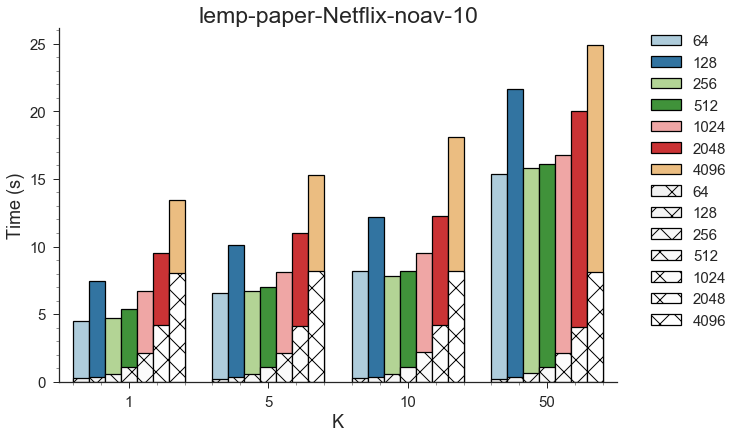

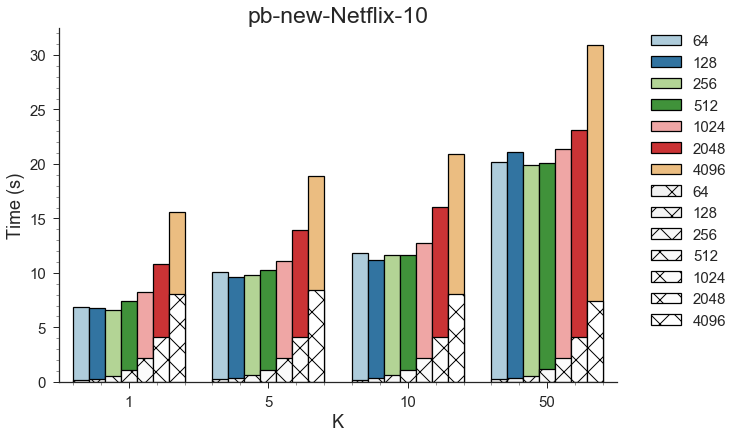

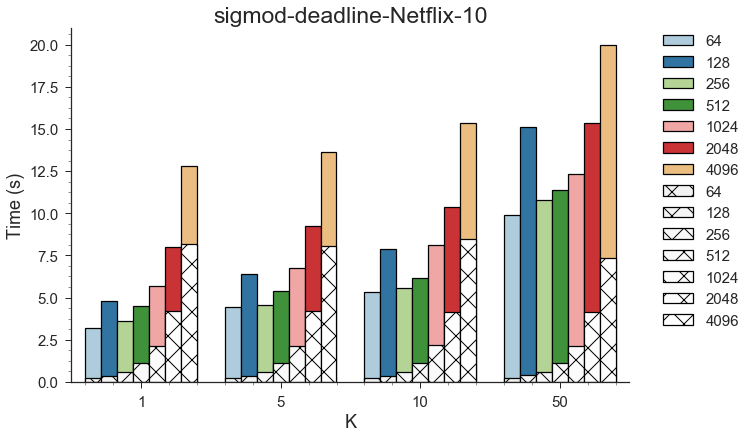

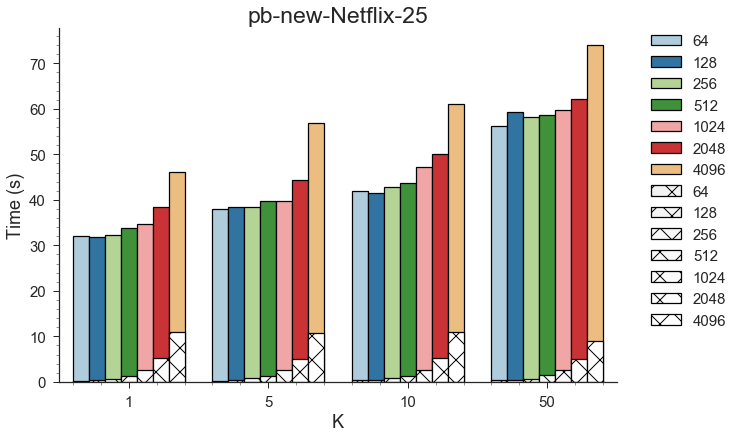

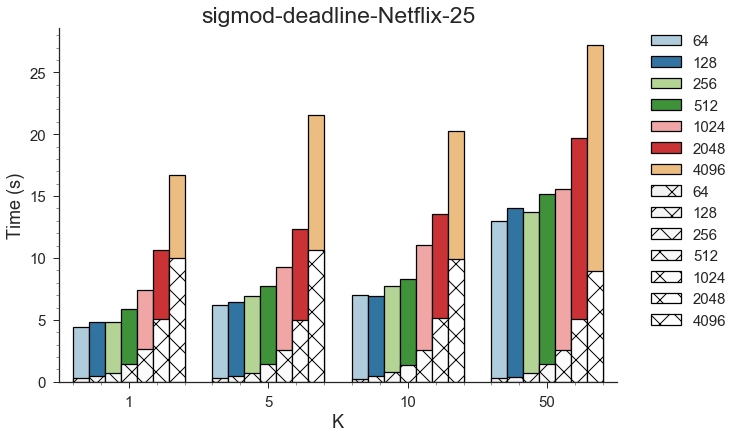

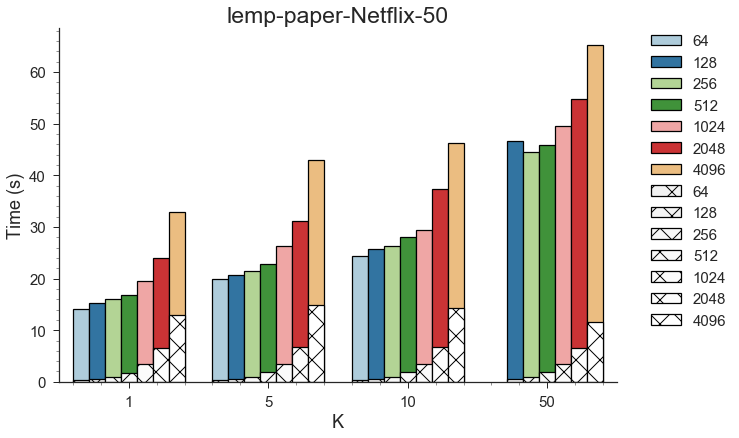

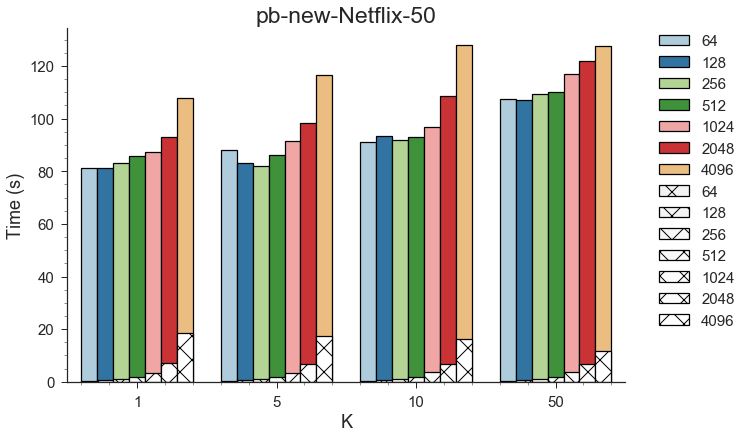

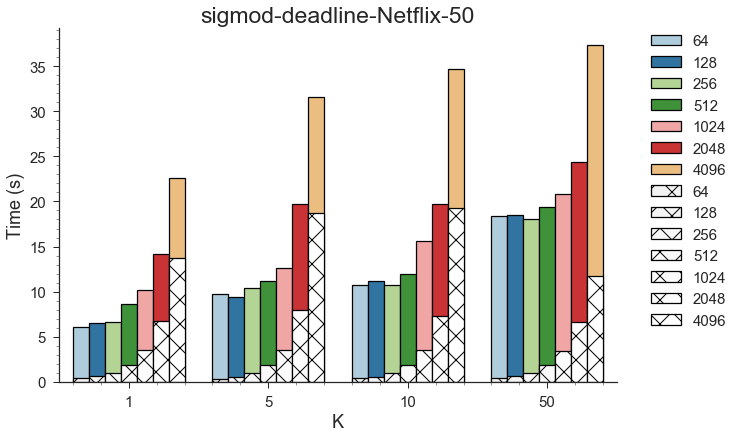

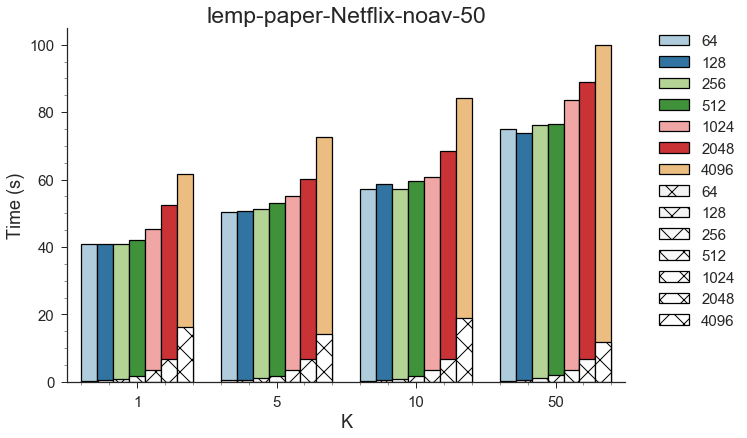

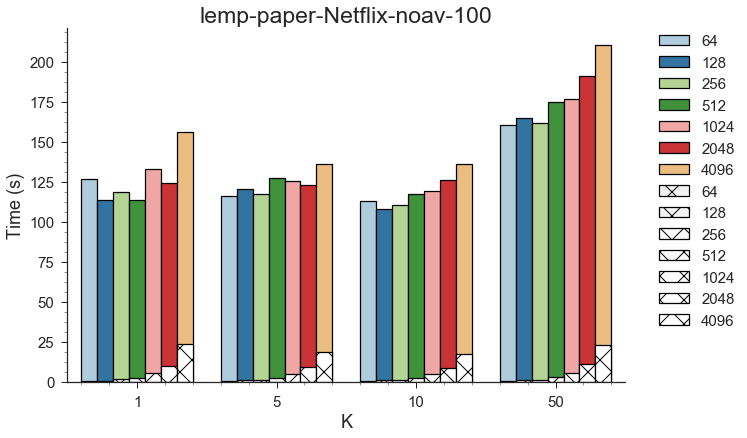

In [6]:
throughput_vs_num_clusters(simdex_df)